# IMAGE CLASSIFICATION AND DETECTION USING SIFT

# classification

Model Training Complete. Accuracy: 0.7692


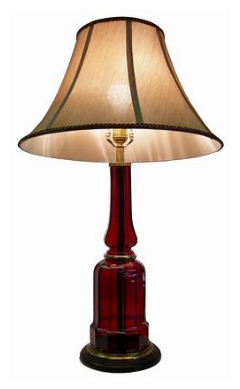

Predicted  Class: lamp


In [23]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dataset_path = r"C:\Users\madhu\Downloads\madhu dataset - Copy"
classes = os.listdir(dataset_path)  # Get class names from dataset folder

def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((128,))
    return np.mean(descriptors, axis=0)  # Take mean for fixed-length feature

def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                      orientations=9, visualize=True)
    return features

def extract_gloh_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        return np.zeros((128,))
    return np.var(descriptors, axis=0)

X, y = [], []

for label, flower in enumerate(classes):
    flower_path = os.path.join(dataset_path, flower)
    for img_name in os.listdir(flower_path):
        img_path = os.path.join(flower_path, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (128, 128))
        
        sift_feat = extract_sift_features(image)
        hog_feat = extract_hog_features(image)
        gloh_feat = extract_gloh_features(image)
        
        features = np.hstack((sift_feat, hog_feat, gloh_feat))
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = rf(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Training Complete. Accuracy: {accuracy:.4f}")

def classify_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    
    sift_feat = extract_sift_features(image)
    hog_feat = extract_hog_features(image)
    gloh_feat = extract_gloh_features(image)
    
    features = np.hstack((sift_feat, hog_feat, gloh_feat)).reshape(1, -1)
    features = scaler.transform(features)
    
    pred_label = clf.predict(features)[0]
    predicted_class = classes[pred_label]
    
    print(f"Predicted  Class: {predicted_class}")

t = r"C:\Users\madhu\Downloads\lamp.jpeg"
image = cv2.imread(t)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(image)
plt.show()

classify_image(t)


# detection

Number of estimated clusters: 8


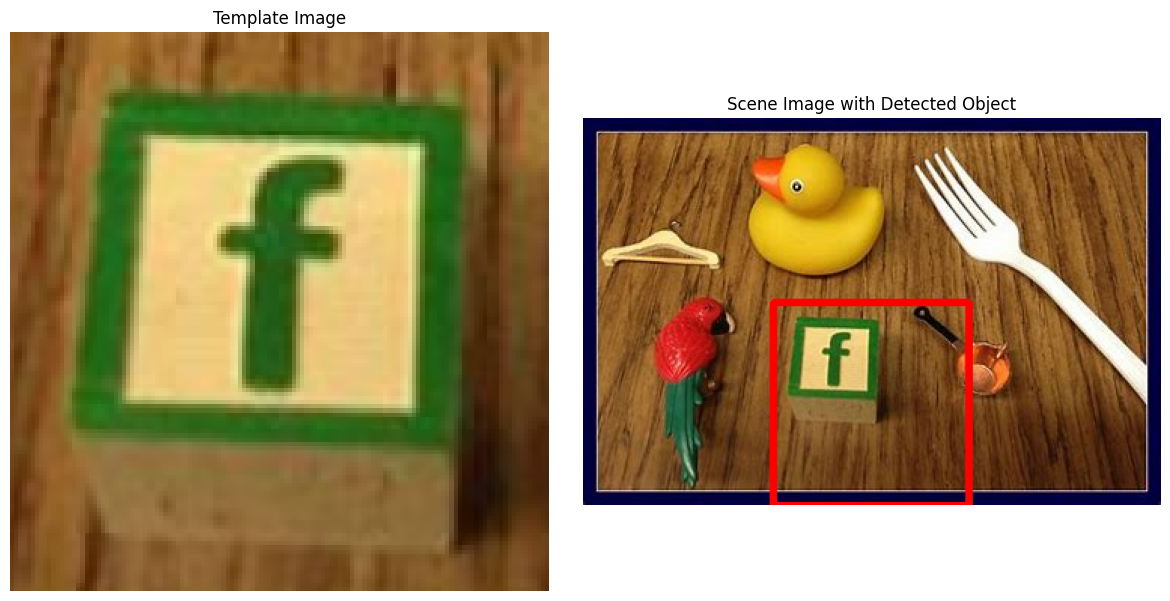

In [17]:
import cv2 
from matplotlib import pyplot as plt 
import numpy as np 
from sklearn.cluster import MeanShift, estimate_bandwidth 

MIN_MATCH_COUNT = 3 

# Read images
img2 = cv2.imread(r"C:\Users\madhu\Downloads\objects.jpeg")  # Scene image
img1 = cv2.imread(r"C:\Users\madhu\OneDrive\Pictures\Screenshots\Screenshot 2025-03-17 211340.png")  # Template image

# Convert img2 for drawing later
img_rgb = img2.copy()

# Initialize SIFT
alg = cv2.SIFT_create()  # Use xfeatures2d.SIFT_create() for older OpenCV versions

# Detect keypoints and descriptors
kp1, des1 = alg.detectAndCompute(img1, None) 
kp2, des2 = alg.detectAndCompute(img2, None) 

# Prepare data for clustering
x = np.array([kp2[0].pt]) 
for i in range(len(kp2)): 
    x = np.append(x, [kp2[i].pt], axis=0) 
x = x[1:len(x)]  # Remove duplicate of first point

# Estimate bandwidth and apply MeanShift clustering
bandwidth = estimate_bandwidth(x, quantile=0.1, n_samples=500) 
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True) 
ms.fit(x) 

labels = ms.labels_ 
cluster_centers = ms.cluster_centers_ 
labels_unique = np.unique(labels) 
n_clusters_ = len(labels_unique) 
print("Number of estimated clusters: %d" % n_clusters_) 

# Group keypoints by cluster
s = [None] * n_clusters_ 
for i in range(n_clusters_): 
    l = ms.labels_ 
    d, = np.where(l == i) 
    s[i] = list(kp2[xx] for xx in d) 

des2_ = des2 

# Loop through clusters
for i in range(n_clusters_): 
    kp2 = s[i] 
    d, = np.where(labels == i) 
    des2 = des2_[d, :] 

    if len(kp2) < 2 or len(kp1) < 2: 
        continue 

    # FLANN matcher
    FLANN_INDEX_KDTREE = 0 
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5) 
    search_params = dict(checks=50) 
    flann = cv2.FlannBasedMatcher(index_params, search_params) 

    des1 = np.float32(des1) 
    des2 = np.float32(des2) 

    matches = flann.knnMatch(des1, des2, 2) 
    good = [] 

    for m, n in matches: 
        if m.distance < 0.5 * n.distance: 
            good.append(m)  

    # Proceed if enough good matches
    if len(good) > MIN_MATCH_COUNT: 
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2) 
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2) 

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 2) 
        if M is None: 
            print("No Homography")
            continue

        # Draw bounding box
        h, w = img1.shape[:2] 
        corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2) 
        transformedCorners = cv2.perspectiveTransform(corners, M) 

        x = int(transformedCorners[0][0][0]) 
        y = int(transformedCorners[0][0][1]) 

        # Draw rectangle and polygon
        cv2.rectangle(img_rgb, (x, y), (x+w, y+h), (0, 0, 255), 3) 
        img2 = cv2.polylines(img2, [np.int32(transformedCorners)], True, (0, 0, 255), 2, cv2.LINE_AA)  

   
# Convert images for matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB) 

# Plot using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(121) 
plt.title('Template Image') 
plt.axis('off') 
plt.imshow(img1_rgb) 

plt.subplot(122) 
plt.title('Scene Image with Detected Object') 
plt.axis('off') 
plt.imshow(img_rgb) 

plt.tight_layout()
plt.show()
